# Chapter: 14
## Section: Self-supervised learning with PyTorch

In [ ]:
!pip install torch
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

# Setting device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.Flowers102(root='./data', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 344862509/344862509 [00:12<00:00, 28265242.31it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 782728.85it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13927430.81it/s]


In [3]:
# Defining the Convolutional Autoencoder
class ConvAE(nn.Module):
    def __init__(self):
      super(ConvAE, self).__init__()
      # Encoding data
      self.encoding_conv1 = nn.Conv2d(3, 8, 3, padding=1)
      self.encoding_conv2 = nn.Conv2d(8, 32, 3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)
      # Decoding data
      self.decoding_conv1 = nn.ConvTranspose2d(32, 8, 2, stride=2)
      self.decoding_conv2 = nn.ConvTranspose2d(8, 3, 2, stride=2)

    def forward(self, x):
      # Encoding data
      x = torch.relu(self.encoding_conv1(x))
      x = self.pool(x)
      x = torch.relu(self.encoding_conv2(x))
      x = self.pool(x)
      # Decoding data
      x = torch.relu(self.decoding_conv1(x))
      x = self.decoding_conv2(x)
      x = torch.sigmoid(x)

      return x

In [4]:
# Initializing the model, loss function and optimizer
model = ConvAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Function to create mask
def create_mask(size=(32, 32), mask_size=8):
    mask = np.ones((3, size[0], size[1]), dtype=np.float32)  # ensure the mask is of type float32
    height, width = size
    m_height, m_width = mask_size, mask_size
    top = np.random.randint(0, height - m_height)
    left = np.random.randint(0, width - m_width)
    mask[:, top:top+m_height, left:left+m_width] = 0
    return torch.from_numpy(mask)

In [6]:
# Training the model
n_epoch = 200
for epoch in range(n_epoch):
    for data in train_loader:
        img, _ = data
        # Creating mask for small part in training images
        mask = create_mask().to(device)
        img_masked = img * mask
        img = img.to(device)
        img_masked = img_masked.to(device)

        optimizer.zero_grad()
        outputs = model(img_masked)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0845
Epoch:2, Loss:0.0732
Epoch:3, Loss:0.0495
Epoch:4, Loss:0.0328
Epoch:5, Loss:0.0309
Epoch:6, Loss:0.0290
Epoch:7, Loss:0.0271
Epoch:8, Loss:0.0244
Epoch:9, Loss:0.0223
Epoch:10, Loss:0.0207
Epoch:11, Loss:0.0235
Epoch:12, Loss:0.0250
Epoch:13, Loss:0.0235
Epoch:14, Loss:0.0220
Epoch:15, Loss:0.0211
Epoch:16, Loss:0.0232
Epoch:17, Loss:0.0220
Epoch:18, Loss:0.0230
Epoch:19, Loss:0.0226
Epoch:20, Loss:0.0203
Epoch:21, Loss:0.0209
Epoch:22, Loss:0.0210
Epoch:23, Loss:0.0173
Epoch:24, Loss:0.0241
Epoch:25, Loss:0.0200
Epoch:26, Loss:0.0218
Epoch:27, Loss:0.0167
Epoch:28, Loss:0.0220
Epoch:29, Loss:0.0178
Epoch:30, Loss:0.0194
Epoch:31, Loss:0.0240
Epoch:32, Loss:0.0217
Epoch:33, Loss:0.0163
Epoch:34, Loss:0.0207
Epoch:35, Loss:0.0245
Epoch:36, Loss:0.0227
Epoch:37, Loss:0.0193
Epoch:38, Loss:0.0214
Epoch:39, Loss:0.0196
Epoch:40, Loss:0.0183
Epoch:41, Loss:0.0197
Epoch:42, Loss:0.0183
Epoch:43, Loss:0.0181
Epoch:44, Loss:0.0185
Epoch:45, Loss:0.0190
Epoch:46, Loss:0.01

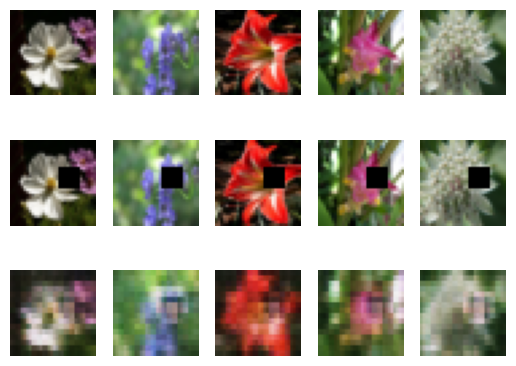

In [7]:
# Visualizing the image inpainting
images, _ = next(iter(train_loader))
mask = create_mask().to(device)
images_masked = images * mask

model.eval()
with torch.no_grad():
    reconstructions = model(images_masked.to(device))
    # Comparing original images with their reconstructions
    fig, ax = plt.subplots(3, 5)
    for i in range(5):
      ax[0, i].imshow(images[i].permute(1, 2, 0))
      ax[0, i].set_axis_off()
      ax[1, i].imshow(images_masked[i].cpu().permute(1, 2, 0))
      ax[1, i].set_axis_off()
      ax[2, i].imshow(reconstructions[i].cpu().permute(1, 2, 0))
      ax[2, i].set_axis_off()
    plt.axis('off')
    plt.show()